# [실습6] AI 기법 성능 향상 방법론


---

## 실습 목표
---
- 하이퍼 매개변수 튜닝에 대해 배워봅니다.
- K-fold 교차 검증을 수행해봅니다.
- Residual network를 구현해봅니다.
- Positional encoding을 구현해봅니다.
- 금속분말 데이터셋에 대한 최적의 인공지능 모델을 구현해봅니다.

## 실습 목차
---
1. **Hyper-parameter 튜닝:** 하이퍼 매개변수 튜닝을 수행해봅니다.

2. **K-fold 교차검증:** K-fold 교차검증으로 모델을 평가해봅니다.

3. **Residual network:** Residual network를 구현해봅니다.

4. **Positional encoding:** Positional encoding을 구현해봅니다.

5. **최적의 모델 구현:** 여태까지 배웠던 것들을 종합하여 최적의 인공지능 모델을 만들어봅니다.

## 실습 개요
---

이번 실습에서는 AI 모델의 성능 향상을 위한 다양한 기법을 수행해봅니다.

## 1. Hyper-parameter 튜닝
---
금속분말 데이터셋을 이용하여 하이퍼 매개변수 튜닝을 수행해보겠습니다.


### 1.1 라이브러리 불러오기

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input
import json
import sklearn.metrics

2025-02-11 04:18:54.142278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 04:18:54.243849: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 04:18:54.274420: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 04:18:55.363715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### 1.2 데이터셋 읽어오기

In [2]:
stage1 = {
    "train_X": np.load("./Data/train_data_stage1_X.npy"),
    "train_y": np.load("./Data/train_data_stage1_y.npy"),
    "valid_X": np.load("./Data/valid_data_stage1_X.npy"),
    "valid_y": np.load("./Data/valid_data_stage1_y.npy"),
    "test_X": np.load("./Data/test_data_stage1_X.npy"),
    "test_y": np.load("./Data/test_data_stage1_y.npy"),
}

stage2 = {
    "train_X": np.load("./Data/train_data_stage2_X.npy"),
    "train_y": np.load("./Data/train_data_stage2_y.npy"),
    "valid_X": np.load("./Data/valid_data_stage2_X.npy"),
    "valid_y": np.load("./Data/valid_data_stage2_y.npy"),
    "test_X": np.load("./Data/test_data_stage2_X.npy"),
    "test_y": np.load("./Data/test_data_stage2_y.npy"),
}

columns = json.load(open("./Data/valid_columns.json", "r"))

### 1.3 데이터 표준화하기

### 1.3.1 Stage1 데이터 표준화하기

In [3]:
stage1_X_mean = stage1["train_X"].mean(axis=0)
stage1_y_mean = stage1["train_y"].mean(axis=0)
print("입력값 평균:", stage1_X_mean)
print("출력값 평균:", stage1_y_mean)

입력값 평균: [  11.85294587  205.74478705  951.00255435 1242.437388     72.01273285
   72.01162996   70.34571071   11.07603585  408.95062376   81.47648118
   75.96962985   12.79330524  566.38390195  202.65058918   68.99620414
   69.10054828   73.3958155    13.89662164  226.12474952   76.81680896
   59.99898793    9.08815439  205.71384206  425.06943434  202.26546402
   78.00841235   78.00453278  345.11532917   13.26721071  246.73680272
   74.14375402   65.00868711  108.96768422   84.98831262   80.00354672
   15.32405834   23.84402174]
출력값 평균: [12.89768652 13.69662267  8.00480187 11.36113325 21.31940678 32.87843839
  0.12721732  1.34725458  1.09990652 19.8051213   7.68305334  1.4919701
  1.20588607  2.89104562 10.02515553]


In [4]:
stage1_X_std = stage1["train_X"].std(axis=0)
stage1_y_std = stage1["train_y"].std(axis=0)
print("입력값 표준편차:", stage1_X_std)
print("출력값 표준편차:", stage1_y_std)

입력값 표준편차: [5.10993143e-01 1.16806618e+01 1.27620111e+02 9.77321235e+01
 6.23396785e-02 4.06238919e-01 5.49867530e+00 6.36170724e-01
 2.05368437e+01 9.21642493e-01 2.06429784e+00 1.07360805e-01
 1.83380514e+01 1.48381842e+01 5.44970706e-02 1.06721153e-01
 3.94100055e-01 2.91335938e-02 3.06908107e+00 8.30358591e-01
 1.61971729e-01 3.95092636e-01 1.63223059e+01 9.53699574e+00
 1.58921785e+01 7.73526529e-02 1.14547773e-01 9.05396328e+00
 4.34061012e-01 6.10492128e+00 2.05042127e+00 6.27961350e-02
 5.59761035e+00 1.85637963e+01 1.18126539e-01 1.18770739e+00
 3.72221796e-01]
출력값 표준편차: [0.9270819  0.85503751 6.90580271 1.03664992 2.14313701 3.882343
 0.57606676 1.13060617 1.41265541 4.68687927 1.07824517 2.54294205
 0.66114934 0.92884134 7.38778856]


In [5]:
# 학습 데이터 표준화
stage1["train_X"] = (stage1["train_X"] - stage1_X_mean) / stage1_X_std
stage1["train_y"] = (stage1["train_y"] - stage1_y_mean) / stage1_y_std
# 검증용 데이터 표준화
stage1["valid_X"] = (stage1["valid_X"] - stage1_X_mean) / stage1_X_std
stage1["valid_y"] = (stage1["valid_y"] - stage1_y_mean) / stage1_y_std
# 테스트 데이터 표준화
stage1["test_X"] = (stage1["test_X"] - stage1_X_mean) / stage1_X_std
stage1["test_y"] = (stage1["test_y"] - stage1_y_mean) / stage1_y_std

### 1.3.2 Stage2 데이터 표준화하기

In [6]:
stage2_X_mean = stage2["train_X"].mean(axis=0)
stage2_y_mean = stage2["train_y"].mean(axis=0)
print("입력값 평균:", stage2_X_mean)
print("출력값 평균:", stage2_y_mean)

입력값 평균: [1.28976865e+01 1.36966227e+01 8.00480187e+00 1.13611333e+01
 2.13194068e+01 3.28784384e+01 1.27217323e-01 1.34725458e+00
 1.09990652e+00 1.98051213e+01 7.68305334e+00 1.49197010e+00
 1.20588607e+00 2.89104562e+00 1.00251555e+01 3.60122933e+02
 3.60136275e+02 1.72294333e+01 3.22627969e+02 3.09786854e+02
 1.87200947e+02 3.09998282e+02 2.89997582e+02 2.69681649e+02
 2.42661246e+02 2.44994629e+02 6.34195390e+01 1.54046742e+02
 1.53240583e+01 2.38440217e+01]
출력값 평균: [11.69212911  6.25614828 10.2499656  19.33555126  2.87697932  2.7475277
  0.53310706  2.91750962 18.38898671 11.61424043  7.53420311  3.54181714
  7.51699723]


In [7]:
stage2_X_std = stage2["train_X"].std(axis=0)
stage2_y_std = stage2["train_y"].std(axis=0)
print("입력값 표준편차:", stage2_X_std)
print("출력값 표준편차:", stage2_y_std)

입력값 표준편차: [ 0.9270819   0.85503751  6.90580271  1.03664992  2.14313701  3.882343
  0.57606676  1.13060617  1.41265541  4.68687927  1.07824517  2.54294205
  0.66114934  0.92884134  7.38778856  1.9209727   2.64895901  0.94209921
  3.61537985  2.74078134 23.41676809  0.03961971  0.05202987  1.01853204
  1.59098238  0.10771334  0.39587306  9.90869048  1.18770739  0.3722218 ]
출력값 표준편차: [3.62230517 1.60057596 2.30753588 4.62537631 9.09270122 0.37574164
 0.20467783 0.49744294 4.97294003 7.62127826 1.64901449 0.45450424
 2.0723342 ]


In [8]:
# 학습 데이터 표준화
stage2["train_X"] = (stage2["train_X"] - stage2_X_mean) / stage2_X_std
stage2["train_y"] = (stage2["train_y"] - stage2_y_mean) / stage2_y_std

# 검증용 데이터 표준화
stage2["valid_X"] = (stage2["valid_X"] - stage2_X_mean) / stage2_X_std
stage2["valid_y"] = (stage2["valid_y"] - stage2_y_mean) / stage2_y_std

# 테스트 데이터 표준화
stage2["test_X"] = (stage2["test_X"] - stage2_X_mean) / stage2_X_std
stage2["test_y"] = (stage2["test_y"] - stage2_y_mean) / stage2_y_std

### 1.4 Hyper-parameter 범위 설정하기

랜덤 서치를 이용한 하이퍼파라미터 설정을 해봅니다. 이때 실습 시간을 고려하여, 학습데이터 중 1000개만 사용해봅니다.

In [9]:
learning_rate = [0.005, 0.03]
dropout_rate = [0.0, 0.2]
trials = 10

In [10]:
def sampling(parameter_range):
    min_value, max_value = parameter_range
    random_value = np.random.random()
    return random_value * (max_value - min_value) + min_value

In [11]:
lrs = []
drs = []
r2s = []
for try_ in range(trials):
    np.random.seed(try_)
    lr = sampling(learning_rate)
    dr = sampling(dropout_rate)
    print("%d 번째 시도 - 학습률: %.3f, dropout rate: %.3f" % (try_ + 1, lr, dr))

    # 모델 정의
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)
    MLP_model = tf.keras.Sequential(
        [
            Input(shape=stage1["train_X"].shape[1]),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(rate=dr),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dropout(rate=dr),
            tf.keras.layers.Dense(stage1["train_y"].shape[1]),
        ]
    )
    # 모델 컴파일
    MLP_model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    )
    # 모델 학습
    history = MLP_model.fit(
        stage1["train_X"], stage1["train_y"], epochs=10, batch_size=16, verbose=0
    )
    # 모델 예측
    pred = MLP_model.predict(stage1["test_X"])
    # 모델 평가
    r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
    print("    -> R2 score: %f" % r2)
    lrs.append(lr)
    drs.append(dr)
    r2s.append(r2)

1 번째 시도 - 학습률: 0.019, dropout rate: 0.143


2025-02-11 04:18:58.636593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-02-11 04:18:58.636618: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-11 04:18:58.636643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (03c3e3c5d2c5): /proc/driver/nvidia/version does not exist
2025-02-11 04:18:58.636895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


36/36 [==============================] - 0s 863us/step
    -> R2 score: 0.369988
2 번째 시도 - 학습률: 0.015, dropout rate: 0.144
36/36 [==============================] - 0s 789us/step
    -> R2 score: 0.353652
3 번째 시도 - 학습률: 0.016, dropout rate: 0.005
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.389318
4 번째 시도 - 학습률: 0.019, dropout rate: 0.142
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.370839
5 번째 시도 - 학습률: 0.029, dropout rate: 0.109
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.433787
6 번째 시도 - 학습률: 0.011, dropout rate: 0.174
36/36 [==============================] - 0s 2ms/step
    -> R2 score: 0.316726
7 번째 시도 - 학습률: 0.027, dropout rate: 0.066
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.440473
8 번째 시도 - 학습률: 0.007, dropout rate: 0.156
36/36 [==============================] - 0s 2ms/step
    -> R2 score: 0.287325
9 번째 시도 - 학습률: 0.027, dropout rate: 0.194
36/36 [=====================

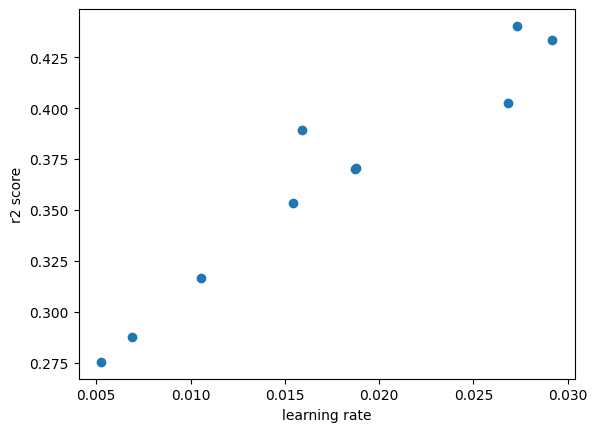

In [12]:
plt.scatter(lrs, r2s)
plt.xlabel("learning rate")
plt.ylabel("r2 score")
plt.show()

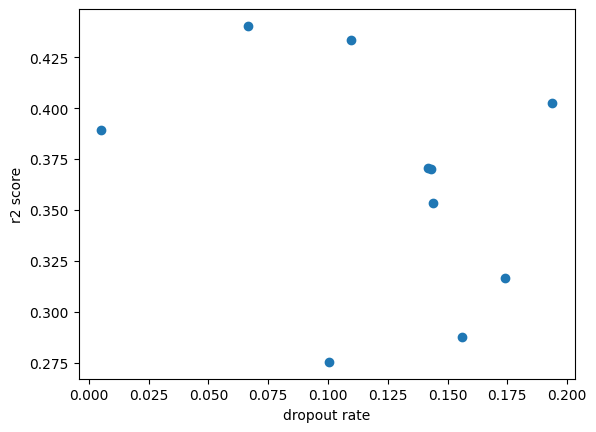

In [13]:
plt.scatter(drs, r2s)
plt.xlabel("dropout rate")
plt.ylabel("r2 score")
plt.show()

In [14]:
np.corrcoef(lrs, r2s)[1, 0]

0.9628329835588891

In [15]:
np.corrcoef(drs, r2s)[1, 0]

-0.29735801256983596

학습률은 모델의 성능과 상관 관계가 큰 반면, dropout rate는 비교적 상관 관계가 약한 것을 확인할 수 있습니다.

**[TODO] Stage 2 데이터에 대해 hyper-parameter 튜닝을 수행해보세요.**

In [16]:
lrs = []
drs = []
r2s = []
for try_ in range(trials):
    np.random.seed(try_)
    lr = sampling(learning_rate)
    dr = sampling(dropout_rate)
    print("%d 번째 시도 - 학습률: %.3f, dropout rate: %.3f" % (try_ + 1, lr, dr))

    # 모델 정의
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)
    MLP_model = tf.keras.Sequential(
        [
            Input(shape=stage2["train_X"].shape[1]),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(rate=dr),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dropout(rate=dr),
            tf.keras.layers.Dense(stage2["train_y"].shape[1]),
        ]
    )
    # 모델 컴파일
    MLP_model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    )
    # 모델 학습
    history = MLP_model.fit(
        stage2["train_X"], stage2["train_y"], epochs=10, batch_size=16, verbose=0
    )
    # 모델 예측
    pred = MLP_model.predict(stage2["test_X"])
    # 모델 평가
    r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
    print("    -> R2 score: %f" % r2)
    lrs.append(lr)
    drs.append(dr)
    r2s.append(r2)

1 번째 시도 - 학습률: 0.019, dropout rate: 0.143
36/36 [==============================] - 0s 2ms/step
    -> R2 score: 0.562740
2 번째 시도 - 학습률: 0.015, dropout rate: 0.144
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.557272
3 번째 시도 - 학습률: 0.016, dropout rate: 0.005
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.586172
4 번째 시도 - 학습률: 0.019, dropout rate: 0.142
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.563757
5 번째 시도 - 학습률: 0.029, dropout rate: 0.109
36/36 [==============================] - 1s 1ms/step
    -> R2 score: 0.590217
6 번째 시도 - 학습률: 0.011, dropout rate: 0.174
36/36 [==============================] - 0s 2ms/step
    -> R2 score: 0.536216
7 번째 시도 - 학습률: 0.027, dropout rate: 0.066
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.601715
8 번째 시도 - 학습률: 0.007, dropout rate: 0.156
36/36 [==============================] - 0s 1ms/step
    -> R2 score: 0.525366
9 번째 시도 - 학습률: 0.027, dropout ra

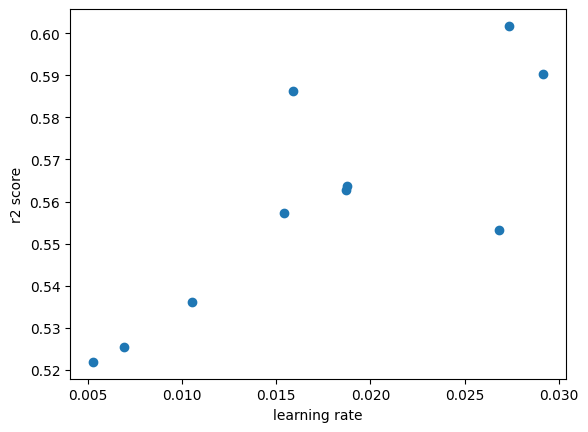

In [17]:
plt.scatter(lrs, r2s)
plt.xlabel("learning rate")
plt.ylabel("r2 score")
plt.show()

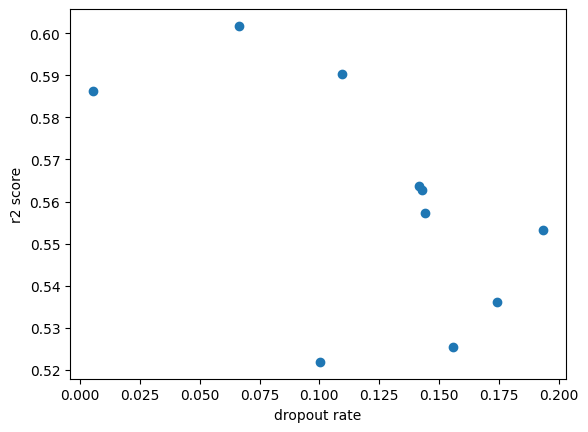

In [18]:
plt.scatter(drs, r2s)
plt.xlabel("dropout rate")
plt.ylabel("r2 score")
plt.show()

In [19]:
np.corrcoef(lrs, r2s)[1, 0]

0.8099436805032751

In [20]:
np.corrcoef(drs, r2s)[1, 0]

-0.5734529468299241

Stage2 에서도 마찬가지로 학습률이 전체 성능에 큰 영향을 미치는 것을 확인할 수 있습니다.

## 2. K-fold 교차 검증

### 2.1 데이터 합치기

In [21]:
X_stage1 = np.concatenate([stage1["train_X"], stage1["valid_X"]])
y_stage1 = np.concatenate([stage1["train_y"], stage1["valid_y"]])

In [22]:
def get_K_fold_dataset(X, y, K):
    dataset = {}
    len_data = len(X)
    idxs = np.arange(len_data)
    for k in range(K):
        training_idxs = np.concatenate(
            [idxs[: int(len_data * k / K)], idxs[int(len_data * (k + 1) / K) :]]
        )
        valid_idxs = idxs[int(len_data * k / K) : int(len_data * (k + 1) / K)]
        dataset["%d-fold" % (k + 1)] = {
            "train_X": X[training_idxs],
            "valid_X": X[valid_idxs],
            "train_y": y[training_idxs],
            "valid_y": y[valid_idxs],
        }
    return dataset

데이터를 K 개의 학습-테스트 셋으로 분리하는 함수를 정의합니다.

In [23]:
K_fold = get_K_fold_dataset(X_stage1, y_stage1, 5)

In [24]:
r2s = []
for K in K_fold.keys():
    dataset = K_fold[K]
    print("%s" % K)
    # 모델 정의
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)
    MLP_model = tf.keras.Sequential(
        [
            Input(shape=stage1["train_X"].shape[1]),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(stage1["train_y"].shape[1]),
        ]
    )
    # 모델 컴파일
    MLP_model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.SGD(),
    )
    # 모델 학습
    history = MLP_model.fit(
        dataset["train_X"], dataset["train_y"], epochs=10, batch_size=16, verbose=0
    )
    # 모델 예측
    pred = MLP_model.predict(dataset["valid_X"])
    # 모델 평가
    r2 = sklearn.metrics.r2_score(dataset["valid_y"], pred)
    print("    -> R2 score: %f" % r2)
    r2s.append(r2)

1-fold
64/64 [==============================] - 0s 1ms/step
    -> R2 score: 0.335456
2-fold
64/64 [==============================] - 0s 2ms/step
    -> R2 score: 0.338193
3-fold
64/64 [==============================] - 0s 2ms/step
    -> R2 score: 0.335656
4-fold
64/64 [==============================] - 0s 2ms/step
    -> R2 score: 0.341695
5-fold
64/64 [==============================] - 0s 1ms/step
    -> R2 score: 0.332775


In [25]:
Average_r2 = np.mean(r2s)
print("Average R2 score: %f" % Average_r2)

Average R2 score: 0.336755


모델의 최종 성능을 평가할 때에는, K개의 fold에서 나온 성능의 평균을 취합니다.

**[TODO] Stage2 데이터에 대해 K-fold 교차검증을 수행해보세요.**

In [26]:
X_stage2 = np.concatenate([stage2["train_X"], stage2["valid_X"]])
y_stage2 = np.concatenate([stage2["train_y"], stage2["valid_y"]])

In [27]:
K_fold = get_K_fold_dataset(X_stage2, y_stage2, 5)

In [28]:
r2s = []
for K in K_fold.keys():
    dataset = K_fold[K]
    print("%s" % K)
    # 모델 정의
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)
    MLP_model = tf.keras.Sequential(
        [
            Input(shape=stage2["train_X"].shape[1]),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(stage2["train_y"].shape[1]),
        ]
    )
    # 모델 컴파일
    MLP_model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.SGD(),
    )
    # 모델 학습
    history = MLP_model.fit(
        dataset["train_X"], dataset["train_y"], epochs=10, batch_size=16, verbose=0
    )
    # 모델 예측
    pred = MLP_model.predict(dataset["valid_X"])
    # 모델 평가
    r2 = sklearn.metrics.r2_score(dataset["valid_y"], pred)
    print("    -> R2 score: %f" % r2)
    r2s.append(r2)

1-fold
64/64 [==============================] - 0s 1ms/step
    -> R2 score: 0.562562
2-fold
64/64 [==============================] - 0s 2ms/step
    -> R2 score: 0.547057
3-fold
64/64 [==============================] - 0s 1ms/step
    -> R2 score: 0.587702
4-fold
64/64 [==============================] - 0s 1ms/step
    -> R2 score: 0.546706
5-fold
64/64 [==============================] - 0s 1ms/step
    -> R2 score: 0.581458


In [29]:
Average_r2 = np.mean(r2s)
print("Average R2 score: %f" % Average_r2)

Average R2 score: 0.565097


## 3. Residual network

### 3.1 Residual network 정의

In [30]:
class ResidualMLP(tf.keras.Model):
    def __init__(self, out_dim, use_residual):
        super(ResidualMLP, self).__init__()
        self.use_residual = use_residual

        self.fc1 = tf.keras.layers.Dense(16, activation="relu")
        self.fc2 = tf.keras.layers.Dense(16, activation="relu")
        self.fc3 = tf.keras.layers.Dense(16, activation="relu")
        self.fc4 = tf.keras.layers.Dense(16, activation="relu")
        self.fc5 = tf.keras.layers.Dense(16, activation="relu")
        self.fc6 = tf.keras.layers.Dense(16, activation="relu")
        self.fc7 = tf.keras.layers.Dense(16, activation="relu")
        self.fc8 = tf.keras.layers.Dense(16, activation="relu")
        self.fc9 = tf.keras.layers.Dense(out_dim)

    def call(self, x):
        if self.use_residual:
            h = self.fc1(x)
            h = self.fc2(h) + h
            h = self.fc3(h) + h
            h = self.fc4(h) + h
            h = self.fc5(h) + h
            h = self.fc6(h) + h
            h = self.fc7(h) + h
            h = self.fc8(h) + h
            h = self.fc9(h)
        else:
            h = self.fc1(x)
            h = self.fc2(h)
            h = self.fc3(h)
            h = self.fc4(h)
            h = self.fc5(h)
            h = self.fc6(h)
            h = self.fc7(h)
            h = self.fc8(h)
            h = self.fc9(h)
        return h

Resiudal network 같이 복잡한 네트워크를 정의하기 위해서는 Sequential 보다 위 처럼 직접 class 를 정의하는 것이 편리합니다.

In [31]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
MLP_model_residual = ResidualMLP(stage1["train_y"].shape[1], use_residual=True)

### 3.2 Residual network 컴파일

In [32]:
MLP_model_residual.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

### 3.3 Residual network 학습

In [33]:
history = MLP_model_residual.fit(
    stage1["train_X"], stage1["train_y"], epochs=10, batch_size=16, verbose=2
)

Epoch 1/10
564/564 - 2s - loss: 1.0941 - 2s/epoch - 4ms/step
Epoch 2/10
564/564 - 1s - loss: 0.8083 - 856ms/epoch - 2ms/step
Epoch 3/10
564/564 - 1s - loss: 0.7533 - 877ms/epoch - 2ms/step
Epoch 4/10
564/564 - 1s - loss: 0.7174 - 882ms/epoch - 2ms/step
Epoch 5/10
564/564 - 1s - loss: 0.6866 - 870ms/epoch - 2ms/step
Epoch 6/10
564/564 - 1s - loss: 0.6652 - 859ms/epoch - 2ms/step
Epoch 7/10
564/564 - 1s - loss: 0.6466 - 857ms/epoch - 2ms/step
Epoch 8/10
564/564 - 1s - loss: 0.6313 - 865ms/epoch - 2ms/step
Epoch 9/10
564/564 - 1s - loss: 0.6155 - 837ms/epoch - 1ms/step
Epoch 10/10
564/564 - 1s - loss: 0.5992 - 899ms/epoch - 2ms/step


### 3.4 Residual network 예측 및 평가

In [34]:
pred = MLP_model_residual.predict(stage1["test_X"])

36/36 [==============================] - 0s 1ms/step


In [35]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.413922


### 3.5 일반 MLP 와의 성능 비교

In [36]:
# 모델 정의
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
MLP_model = ResidualMLP(stage1["train_y"].shape[1], use_residual=False)

use_residual 을 False로 설정하여 일반 MLP 네트워크를 정의합니다.

In [37]:
# 모델 컴파일
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

In [38]:
# 모델 학습
history = MLP_model.fit(
    stage1["train_X"], stage1["train_y"], epochs=10, batch_size=16, verbose=2
)

Epoch 1/10
564/564 - 1s - loss: 0.9928 - 1s/epoch - 2ms/step
Epoch 2/10
564/564 - 1s - loss: 0.9574 - 849ms/epoch - 2ms/step
Epoch 3/10
564/564 - 1s - loss: 0.8989 - 883ms/epoch - 2ms/step
Epoch 4/10
564/564 - 1s - loss: 0.8658 - 861ms/epoch - 2ms/step
Epoch 5/10
564/564 - 1s - loss: 0.8509 - 817ms/epoch - 1ms/step
Epoch 6/10
564/564 - 1s - loss: 0.8424 - 856ms/epoch - 2ms/step
Epoch 7/10
564/564 - 1s - loss: 0.8362 - 861ms/epoch - 2ms/step
Epoch 8/10
564/564 - 1s - loss: 0.8307 - 818ms/epoch - 1ms/step
Epoch 9/10
564/564 - 1s - loss: 0.8254 - 859ms/epoch - 2ms/step
Epoch 10/10
564/564 - 1s - loss: 0.8195 - 831ms/epoch - 1ms/step


In [39]:
# 모델 예측
pred = MLP_model.predict(stage1["test_X"])

36/36 [==============================] - 0s 1ms/step


In [40]:
# 모델 평가
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.185611


Residual network 가 더 성능이 좋은 것을 확인할 수 있습니다.

**[TODO] Stage2 데이터에 대해 Residual network 를 학습해보세요.**

In [41]:
# resiudal network 모델 정의
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
MLP_model_residual = ResidualMLP(stage2["train_y"].shape[1], use_residual=True)

# resiudal network 사용하지 않는 모델 정의
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
MLP_model = ResidualMLP(stage2["train_y"].shape[1], use_residual=False)

In [42]:
# 모델 컴파일
MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

MLP_model_residual.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD(),
)

In [43]:
# residual 모델 학습
MLP_model_residual.fit(
    stage2["train_X"], stage2["train_y"], epochs=10, batch_size=16, verbose=2
)

Epoch 1/10
564/564 - 2s - loss: 0.8344 - 2s/epoch - 3ms/step
Epoch 2/10
564/564 - 1s - loss: 0.5627 - 840ms/epoch - 1ms/step
Epoch 3/10
564/564 - 1s - loss: 0.5152 - 867ms/epoch - 2ms/step
Epoch 4/10
564/564 - 1s - loss: 0.4841 - 893ms/epoch - 2ms/step
Epoch 5/10
564/564 - 1s - loss: 0.4644 - 857ms/epoch - 2ms/step
Epoch 6/10
564/564 - 1s - loss: 0.4510 - 854ms/epoch - 2ms/step
Epoch 7/10
564/564 - 1s - loss: 0.4384 - 862ms/epoch - 2ms/step
Epoch 8/10
564/564 - 1s - loss: 0.4309 - 874ms/epoch - 2ms/step
Epoch 9/10
564/564 - 1s - loss: 0.4192 - 841ms/epoch - 1ms/step
Epoch 10/10
564/564 - 1s - loss: 0.4119 - 853ms/epoch - 2ms/step


In [44]:
# 일반 MLP 모델 학습
MLP_model.fit(stage2["train_X"], stage2["train_y"], epochs=10, batch_size=16, verbose=2)

Epoch 1/10
564/564 - 1s - loss: 0.9897 - 1s/epoch - 2ms/step
Epoch 2/10
564/564 - 1s - loss: 0.7984 - 821ms/epoch - 1ms/step
Epoch 3/10
564/564 - 1s - loss: 0.6321 - 833ms/epoch - 1ms/step
Epoch 4/10
564/564 - 1s - loss: 0.6164 - 826ms/epoch - 1ms/step
Epoch 5/10
564/564 - 1s - loss: 0.6065 - 806ms/epoch - 1ms/step
Epoch 6/10
564/564 - 1s - loss: 0.5929 - 820ms/epoch - 1ms/step
Epoch 7/10
564/564 - 1s - loss: 0.5674 - 803ms/epoch - 1ms/step
Epoch 8/10
564/564 - 1s - loss: 0.5379 - 813ms/epoch - 1ms/step
Epoch 9/10
564/564 - 1s - loss: 0.5136 - 831ms/epoch - 1ms/step
Epoch 10/10
564/564 - 1s - loss: 0.4987 - 812ms/epoch - 1ms/step


In [45]:
# Residual 모델 예측
pred = MLP_model_residual.predict(stage2["test_X"])

36/36 [==============================] - 0s 2ms/step


In [46]:
# Residual 모델 평가
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.585829


In [47]:
# 일반 MLP 모델 예측
pred = MLP_model.predict(stage2["test_X"])

36/36 [==============================] - 0s 2ms/step


In [48]:
# 일반 MLP 모델 평가
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.504877


## 4. Positional encoding

In [49]:
def positional_encoding(X, L):
    Xs = []
    for l in range(L):
        Xs.append(np.sin(2**l * np.pi * X))
        Xs.append(np.cos(2**l * np.pi * X))
    return np.concatenate(Xs, axis=-1)

입력 데이터를 L개의 frequency를 가진 데이터로 변환하는 함수를 정의합니다.

In [50]:
train_X = positional_encoding(stage1["train_X"], 5)
test_X = positional_encoding(stage1["test_X"], 5)

In [51]:
train_X.shape

(9016, 370)

In [52]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
MLP_model_pe = ResidualMLP(stage1["train_y"].shape[1], use_residual=True)

In [53]:
MLP_model_pe.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(), metrics=["mse"])

In [54]:
history = MLP_model_pe.fit(
    train_X, stage1["train_y"], epochs=10, batch_size=16, verbose=2
)

Epoch 1/10
564/564 - 2s - loss: 1.0800 - mse: 1.0800 - 2s/epoch - 3ms/step
Epoch 2/10
564/564 - 1s - loss: 0.9951 - mse: 0.9951 - 907ms/epoch - 2ms/step
Epoch 3/10
564/564 - 1s - loss: 0.9449 - mse: 0.9449 - 882ms/epoch - 2ms/step
Epoch 4/10
564/564 - 1s - loss: 0.8596 - mse: 0.8596 - 892ms/epoch - 2ms/step
Epoch 5/10
564/564 - 1s - loss: 0.8163 - mse: 0.8163 - 906ms/epoch - 2ms/step
Epoch 6/10
564/564 - 1s - loss: 0.7966 - mse: 0.7966 - 886ms/epoch - 2ms/step
Epoch 7/10
564/564 - 1s - loss: 0.7834 - mse: 0.7834 - 865ms/epoch - 2ms/step
Epoch 8/10
564/564 - 1s - loss: 0.7680 - mse: 0.7680 - 878ms/epoch - 2ms/step
Epoch 9/10
564/564 - 1s - loss: 0.7478 - mse: 0.7478 - 881ms/epoch - 2ms/step
Epoch 10/10
564/564 - 1s - loss: 0.7244 - mse: 0.7244 - 854ms/epoch - 2ms/step


In [55]:
pred = MLP_model_pe.predict(test_X)

36/36 [==============================] - 0s 2ms/step


In [56]:
r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.281565


**[TODO] Stage2 데이터에 대해 positional encoding 적용해보기**

In [57]:
train_X = positional_encoding(stage2["train_X"], 5)
test_X = positional_encoding(stage2["test_X"], 5)

In [58]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
MLP_model_pe = ResidualMLP(stage2["train_y"].shape[1], use_residual=True)

In [59]:
MLP_model_pe.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(), metrics=["mse"])

In [60]:
history = MLP_model_pe.fit(train_X, stage2['train_y'], epochs=10, batch_size=16, verbose=2)

Epoch 1/10
564/564 - 2s - loss: 0.7475 - mse: 0.7475 - 2s/epoch - 3ms/step
Epoch 2/10
564/564 - 1s - loss: 0.5748 - mse: 0.5748 - 905ms/epoch - 2ms/step
Epoch 3/10
564/564 - 1s - loss: 0.5513 - mse: 0.5513 - 827ms/epoch - 1ms/step
Epoch 4/10
564/564 - 1s - loss: 0.5418 - mse: 0.5418 - 845ms/epoch - 1ms/step
Epoch 5/10
564/564 - 1s - loss: 0.5375 - mse: 0.5375 - 851ms/epoch - 2ms/step
Epoch 6/10
564/564 - 1s - loss: 0.5347 - mse: 0.5347 - 838ms/epoch - 1ms/step
Epoch 7/10
564/564 - 1s - loss: 0.5313 - mse: 0.5313 - 793ms/epoch - 1ms/step
Epoch 8/10
564/564 - 1s - loss: 0.5249 - mse: 0.5249 - 864ms/epoch - 2ms/step
Epoch 9/10
564/564 - 1s - loss: 0.4913 - mse: 0.4913 - 896ms/epoch - 2ms/step
Epoch 10/10
564/564 - 1s - loss: 0.4634 - mse: 0.4634 - 885ms/epoch - 2ms/step


In [61]:
pred = MLP_model_pe.predict(test_X)

36/36 [==============================] - 0s 2ms/step


In [62]:
r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

R2 score: 0.540449


## 5. 최적의 인공지능 모델 구현

여태까지 배운 내용들을 종합하여 금속분말 데이터셋에 대해 최고 성능을 발휘하는 최적의 인공지능 모델을 만들어보세요.

In [65]:
#Stage 1

MLP_model = tf.keras.Sequential([
    Input(shape=stage1["train_X"].shape[1]),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianNoise(stddev=0.1),
    
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianNoise(stddev=0.1),
    
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianNoise(stddev=0.1),
    
    tf.keras.layers.Dense(stage1["train_y"].shape[1]),
])

MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD()
)


history = MLP_model.fit(
    stage1["train_X"],
    stage1["train_y"],
    validation_data=(stage1["valid_X"], stage1["valid_y"]),
    epochs=100,           
    batch_size=16,
    verbose=2,
)

pred = MLP_model.predict(stage1["test_X"])

r2 = sklearn.metrics.r2_score(stage1["test_y"], pred)
print("R2 score: %f" % r2)

Epoch 1/100
564/564 - 3s - loss: 1.0223 - val_loss: 0.8117 - 3s/epoch - 5ms/step
Epoch 2/100
564/564 - 1s - loss: 0.7954 - val_loss: 0.7421 - 1s/epoch - 2ms/step
Epoch 3/100
564/564 - 1s - loss: 0.7519 - val_loss: 0.7108 - 1s/epoch - 2ms/step
Epoch 4/100
564/564 - 1s - loss: 0.7273 - val_loss: 0.6890 - 1s/epoch - 3ms/step
Epoch 5/100
564/564 - 1s - loss: 0.7033 - val_loss: 0.6698 - 1s/epoch - 2ms/step
Epoch 6/100
564/564 - 1s - loss: 0.6914 - val_loss: 0.6594 - 1s/epoch - 2ms/step
Epoch 7/100
564/564 - 1s - loss: 0.6748 - val_loss: 0.6547 - 1s/epoch - 2ms/step
Epoch 8/100
564/564 - 1s - loss: 0.6665 - val_loss: 0.6459 - 1s/epoch - 2ms/step
Epoch 9/100
564/564 - 1s - loss: 0.6537 - val_loss: 0.6392 - 1s/epoch - 2ms/step
Epoch 10/100
564/564 - 1s - loss: 0.6405 - val_loss: 0.6296 - 1s/epoch - 3ms/step
Epoch 11/100
564/564 - 1s - loss: 0.6341 - val_loss: 0.6197 - 1s/epoch - 3ms/step
Epoch 12/100
564/564 - 1s - loss: 0.6274 - val_loss: 0.6085 - 1s/epoch - 2ms/step
Epoch 13/100
564/564 - 1s

36/36 [==============================] - 0s 2ms/step
R2 score: 0.523444


In [66]:
#Stage 2

MLP_model = tf.keras.Sequential([
    Input(shape=stage2["train_X"].shape[1]),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianNoise(stddev=0.1),
    
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianNoise(stddev=0.1),
    
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GaussianNoise(stddev=0.1),
    
    tf.keras.layers.Dense(stage2["train_y"].shape[1]),
])

MLP_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.SGD()
)


history = MLP_model.fit(
    stage2["train_X"],
    stage2["train_y"],
    validation_data=(stage2["valid_X"], stage2["valid_y"]),
    epochs=100,           
    batch_size=16,
    verbose=2,
)

pred = MLP_model.predict(stage2["test_X"])

r2 = sklearn.metrics.r2_score(stage2["test_y"], pred)
print("R2 score: %f" % r2)

Epoch 1/100
564/564 - 3s - loss: 0.8813 - val_loss: 0.6836 - 3s/epoch - 5ms/step
Epoch 2/100
564/564 - 1s - loss: 0.6191 - val_loss: 0.6569 - 1s/epoch - 2ms/step
Epoch 3/100
564/564 - 1s - loss: 0.5602 - val_loss: 0.7447 - 1s/epoch - 2ms/step
Epoch 4/100
564/564 - 2s - loss: 0.5370 - val_loss: 0.7661 - 2s/epoch - 3ms/step
Epoch 5/100
564/564 - 1s - loss: 0.5063 - val_loss: 0.6940 - 1s/epoch - 3ms/step
Epoch 6/100
564/564 - 1s - loss: 0.4963 - val_loss: 0.7160 - 1s/epoch - 3ms/step
Epoch 7/100
564/564 - 1s - loss: 0.4834 - val_loss: 0.6861 - 1s/epoch - 3ms/step
Epoch 8/100
564/564 - 1s - loss: 0.4796 - val_loss: 0.7169 - 1s/epoch - 2ms/step
Epoch 9/100
564/564 - 1s - loss: 0.4617 - val_loss: 0.7332 - 1s/epoch - 2ms/step
Epoch 10/100
564/564 - 1s - loss: 0.4571 - val_loss: 0.6243 - 1s/epoch - 3ms/step
Epoch 11/100
564/564 - 1s - loss: 0.4543 - val_loss: 0.7129 - 1s/epoch - 2ms/step
Epoch 12/100
564/564 - 1s - loss: 0.4441 - val_loss: 0.7071 - 1s/epoch - 3ms/step
Epoch 13/100
564/564 - 1s

36/36 [==============================] - 0s 2ms/step
R2 score: 0.660672


<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>